In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import math
sp.init_printing()
%matplotlib inline

In [53]:
class GradientDescent:
    def __init__(self):
        self.mc = 2   # cart mass
        self.mp = 0.5 # pole mass
        self.g = 9.81 # gravity
        self.l = 0.6  # half pole length
        self.dt = 0.01 # time interval
        # cart position, cart velocity, pole angle, pole angular velocity
        self.initial_state = np.array([-1.0, 0.2, 0.2, -0.4]) 
        # noise
        self.noise = np.array([0.001, 0.002, 0.001, 0.002])

        self.cart_target = [-0.1,0.1]  # target region in meters 
        self.pole_target = [-0.1,0.1]  # target region in radians
        self.k1 = 1
        self.k2 = 1
        self.k3 = 1
        self.k4 = 1
        
    def x_acc(self, F, theta_d, theta):
        x_dd = (F - self.l*self.mp*(self.theta_acc(F, theta_d, theta)*np.cos(theta) - 
                                    np.sin(theta)*theta_d**2))/(self.mp + self.mc)
        return x_dd
    
    def theta_acc(self, F, theta_d, theta):
        theta_dd = (self.g*np.sin(theta)*(self.mp + self.mc) - 
                    (F + self.mp*self.l*np.sin(theta)*theta_d**2)*np.cos(theta)) / ((4/3)*self.l*(self.mc + 
                    self.mp) - self.mp*self.l*np.cos(theta)**2)
        return theta_dd
    
    def state_evolution(self):
        x = self.initial_state[0]
        x_d = self.initial_state[1]
        theta = self.initial_state[2]
        theta_d = self.initial_state[3]
        states = []
        F = 0
        N = 1/self.dt
        # zero mean 
        mean = np.array([0, 0, 0, 0])
        for i in range(int(N)):
            noise = np.random.normal(mean, self.noise)
            x = x + self.dt*x_d + noise[0]
            x_d = x_d + self.dt*self.x_acc(F, theta_d, theta) + noise[1]
            theta = theta + self.dt*theta_d + noise[2]
            theta_d = theta_d + self.dt*self.theta_acc(F, theta_d, theta) + noise[3]
            states.append([x, x_d, theta, theta_d])
        return states 
    
    def run_simulation(self,k1,k2,k3,k4, timesteps):
        reward = 0
        x = self.initial_state[0]
        x_d = self.initial_state[1]
        theta = self.initial_state[2]
        theta_d = self.initial_state[3]
        states = []
        rewards = []
        actions = []
        N = timesteps
        # zero mean 
        mean = np.array([0, 0, 0, 0])
        for i in range(N):
            f = k1*x + k2*x_d + k3*theta + k4*theta_d
            F = min(50,max(-50, f))
            noise = np.random.normal(mean, self.noise)
            x = x + self.dt*x_d + noise[0]
            x_d = x_d + self.dt*self.x_acc(F, theta_d, theta) + noise[1]
            theta = theta + self.dt*theta_d + noise[2]
            theta_d = theta_d + self.dt*self.theta_acc(F, theta_d, theta) + noise[3]
            states.append([x, x_d, theta, theta_d])
            actions.append(F)
            if not (self.pole_target[0] <= theta and theta <= self.pole_target[1]):
                reward = -1
            elif not (self.cart_target[0] <= x and x <= self.cart_target[1]):
                reward = -1
            else:
                reward = 0
            rewards.append(reward)
            if abs(theta) > 1 or abs(x) > 5:
                final_reward = -(N-i)
                return rewards, states, actions, final_reward
            
        return rewards, states, actions, final_reward
    
    def compute_policy(self, states, theta):
        prob_right = self.sigmoid(np.dot(states, np.transpose(theta)))
        return [1-prob_right, prob_right]
    
    def sigmoid(self, u):
        return 1.0 / (1.0 + np.exp(-u))

    def compute_policy_gradient(self, rewards, actions, states, theta):
        gradient = 0
        episode_length = len(rewards)
        for t in range(episode_length):
            # Compute the policy on the observation and theta.
            pi = self.compute_policy(states[t], theta)
            a_t = actions[t]
            v_t = sum(rewards[t::])
            if a_t == 0:
                grad_theta_log_pi = - pi[1] * np.asarray(states[t]) * v_t
            else:
                grad_theta_log_pi = pi[0] * np.asarray(states[t]) * v_t
            gradient = gradient + grad_theta_log_pi
        return gradient
    
    def train_policy_gradient_agent(self, theta, timesteps, episodes, initial_step_size):

        for i_episode in range(episodes):
#             print(i_episode)
            # Run an episode with our current policy
            rewards, states, actions, f_reward = self.run_simulation(theta[0], theta[1], theta[2], theta[3], timesteps)
            print(len(rewards))
            # Compute the policy gradient for this trajectory
            policy_gradient = self.compute_policy_gradient(rewards, actions, states, theta)

            # Vanilla gradient ascent
            # We decrease the step size proportional to 1/i_episode
            step_size = initial_step_size / (1 + i_episode)
            theta = theta + step_size * policy_gradient

        # Return our trained theta
        return theta
    
    def estimate_gradient(self, theta, timesteps, episodes):
        perturbation = []
        J_k = []
        gradient = [0.0,0.0,0.0,0.0]
        for k in range(len(theta)):
            rewards, states, actions, f_reward = self.run_simulation(theta[0], theta[1], theta[2], theta[3], timesteps)
            J_0 = rewards[len(rewards)-1]
            for e in range(episodes):
                d_theta = np.random.rand()*self.noise[k]*2-self.noise[k]
                perturbation.append(d_theta)
                theta[k] = theta[k] + d_theta
                rewards, states, actions, f_reward = self.run_simulation(theta[0], theta[1], theta[2], theta[3], timesteps)
                J = rewards[len(rewards)-1]
                J_k.append(J)
            gradient[k] = np.sum(np.asarray(perturbation)*(np.asarray(J_k)-J_0))/np.sum(np.asarray(perturbation))**2
        return gradient
    
#     def policy_gradient(self,k1, k2, k3, k4, alpha, timesteps, num_episodes):
#         theta = np.array([k1,k2,k3,k4])
#         print(theta)
#         for i_episode in range(num_episodes):
#             gradient = self.estimate_gradient(theta, timesteps, num_episodes)
# #             step_size = alpha / (1 + i_episode)
# #             print(theta)
# #             print(step_size)
# #             print(gradient)
#             theta = theta + alpha *  np.asarray(gradient)
#         return theta

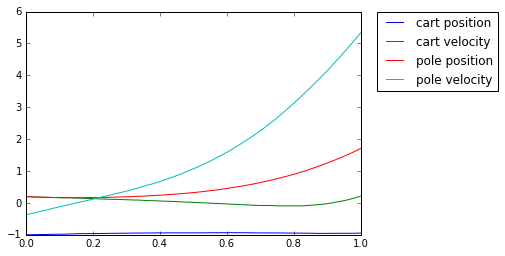

In [54]:
obj = GradientDescent()
states = obj.state_evolution()
states = np.asarray(states)
plt.figure()
x = np.linspace(0,1,100)
cart_p, = plt.plot(x,states[:,0], label='cart position')
cart_v, = plt.plot(x,states[:,1], label='cart velocity')
pole_p, = plt.plot(x,states[:,2], label='pole position')
pole_v, = plt.plot(x,states[:,3], label='pole velocity')
plt.legend(handles=[cart_p,cart_v,pole_p,pole_v],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [55]:
# pd.DataFrame(states)

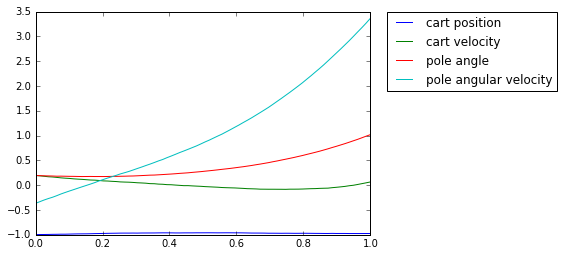

reward: -921
timesteps achieved: 80


In [56]:
k1 = 1.0
k2 = 1.0
k3 = 1.0
k4 = 1.0
timesteps = 1000
reward, states, actions, f_reward = obj.run_simulation(k1,k2,k3,k4, timesteps)
states = np.asarray(states)
plt.figure()
x = np.linspace(0,1,len(states))
cart_p, = plt.plot(x,states[:,0], label='cart position')
cart_v, = plt.plot(x,states[:,1], label='cart velocity')
pole_p, = plt.plot(x,states[:,2], label='pole angle')
pole_v, = plt.plot(x,states[:,3], label='pole angular velocity')
plt.legend(handles=[cart_p,cart_v,pole_p,pole_v],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print('reward: ' + str(f_reward))
print('timesteps achieved: ' + str(len(states)))
# print(reward)

In [57]:
alpha = 0.01
initial_step_size = 0.01
max_episodes = 10
theta = np.array([k1,k2,k3,k4])
theta = obj.train_policy_gradient_agent(theta, timesteps, max_episodes, initial_step_size)
theta

79
34
30
29
28
28
28
28
28
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
26
27
27
27
27
27
27
27
27
27
27
27
27
27
26
27
27
27
27
27
27
26
27
27
27
27
27
27
27
27
27
26
27
27
26
26
27
27
26
26
26
26
27
26
26
26
26
26
26
26
26
26
27
27
26
26
26
27
26
27


array([ 36.90232465,  25.87271519,  -8.26060053, -37.69273118])

In [24]:

theta = obj.policy_gradient(k1,k2,k3,k4,alpha,timesteps,max_episodes)
print(theta)

[ 1.  1.  1.  1.]
[ 1.01004611  1.24652709  0.96372558  0.9424053 ]


reward: -921
timesteps achieved: 79


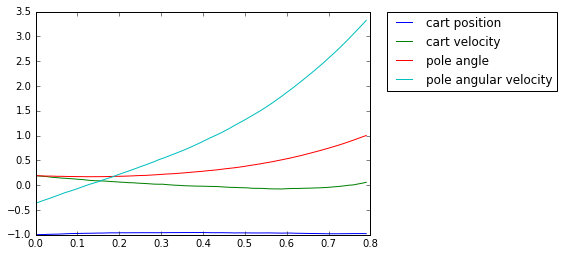

In [28]:
rewards, states, actions, f_rewards = obj.run_simulation(theta[0], theta[1], theta[2], theta[3], timesteps)
print('reward: ' + str(f_reward))
print('timesteps achieved: ' + str(len(states)))
states = np.asarray(states)
plt.figure()
x = np.linspace(0,len(states)*0.01,len(states))
cart_p, = plt.plot(x,states[:,0], label='cart position')
cart_v, = plt.plot(x,states[:,1], label='cart velocity')
pole_p, = plt.plot(x,states[:,2], label='pole angle')
pole_v, = plt.plot(x,states[:,3], label='pole angular velocity')
plt.legend(handles=[cart_p,cart_v,pole_p,pole_v],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
theta